# Movie Success Prediction
### Capstone Project 2
### *Rajesh Dharmarajan*
***
_This is my second Capstone project for my Springboard Data Science Career track. This is a prediction problem to predict the financial success of a movie based on factors that go in to making a movie._

This project has two iPython notebooks, and this is the second notebook. The first notebook is `Predict_Movie_Box_Office_Capstone_2_Data_Collection`. The first one is this where the data is obtained from different sources and put together for the next steps in building the model. This notebook uses the data collected in the first notebook to visualize the data and build suitable prediction models.

In [1]:
import pandas as pd
import numpy as np
import tkinter
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
#matplotlib inline
#%matplotlib notebook
import seaborn as sns
from random import randint
pd.set_option('display.max_columns', None)
from bokeh.io import output_notebook
output_notebook()
from bokeh.io import output_notebook,show
from bokeh.plotting import figure, ColumnDataSource
import calendar
from bokeh.models import HoverTool
#from bokeh.transform import dodge

Loading BokehJS ...

In [2]:
movies_df=pd.read_csv('final_movie_data_df.csv',encoding='Latin')

On analyzing the data, i found that there are a lot of rows (1576 rows out of a total of 2587 rows) that do not have the actor or director score. Unfortunately, Amazon has changed the IMDB datasets hosted on S3 and as a result the IMDBPy function to get movie details does not work any more. So i will not be able to use IMDBPy to get the details untill this issue is fixed. More details of this issue can be found here:
https://github.com/alberanid/imdbpy/issues/103
For now, i will proceed with whatever data that is available, i.e. around 1000 rows. Will come back later if the issue is fixed or find alternate ways to find this data

In [3]:
len(movies_df[np.isnan(movies_df['actor1_score'])])

1576

In [4]:
#remove the rows that do not contain the actor scores
movies_df=movies_df[~(np.isnan(movies_df['actor1_score']))]

In [5]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig'],
      dtype='object')

The release dates were scrapped from www.imdb.com. There were issues in the string date that were obtained,the following function fixes the issues with the dates

In [6]:
def fix_release_dates(date_string,year,title):
    #function to fix the release dates
    try:
        if pd.isnull(date_string) | ('NoReleaseDates' in str(date_string)):
            #could not find release dates for around 400 of the movies
            #will default those to 15the of a random month of the release year
            def_date='15-'+str(randint(1,12))+'-'+str(int(year))
            #print('default date:',def_date)
            conv_date=pd.to_datetime(def_date)
        elif '0 ' in str(date_string)[0:2]:
            #some release dates have the date as '0 January 2010'
            #converting those to 01 January 2010
            def_date='01 '+date_string[2:]
            conv_date=pd.to_datetime(def_date)
        else:
            conv_date = pd.to_datetime(date_string,errors='coerce')
        
        if pd.isnull(conv_date):
            print(title,' ',date_string)
            return('error')
        else:
            return(conv_date)
        #return(date_string)
    except ValueError:
        return('ValueError '+date_string)
    except AssertionError:
        return('AssertionError'+date_string)


#-------------------------------------------------------------------
def build_rel_month_dict(date):
    '''
    This function is used to create dummy columns for the month when the movie is released
    '''
    rel_month = {'Jan':0,'Feb':0,'Mar':0,'Apr':0,'May':0,'Jun':0,'Jul':0,'Aug':0,'Sep':0,'Oct':0,'Nov':0,'Dec':0}
    if date.month==1:
        rel_month['Jan']=1
    elif date.month==2:
        rel_month['Feb']=1
    elif date.month==3:
        rel_month['Mar']=1
    elif date.month==4:
        rel_month['Apr']=1
    elif date.month==5:
        rel_month['May']=1
    elif date.month==6:
        rel_month['Jun']=1
    elif date.month==7:
        rel_month['Jul']=1
    elif date.month==8:
        rel_month['Aug']=1
    elif date.month==9:
        rel_month['Sep']=1
    elif date.month==10:
        rel_month['Oct']=1
    elif date.month==11:
        rel_month['Nov']=1
    elif date.month==12:
        rel_month['Dec']=1
    
    return rel_month


In [7]:
#fix the release dates
movies_df['release_date_upd']=movies_df[['release_date','year','title']].apply(lambda x:fix_release_dates(x['release_date'],x['year'],x['title']),axis=1)

In [8]:
#create dummy columns for the gender of the actors
movies_df['actor1_male']=movies_df['actor1_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor1_female']=movies_df['actor1_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor2_male']=movies_df['actor2_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor2_female']=movies_df['actor2_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor3_male']=movies_df['actor3_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor3_female']=movies_df['actor3_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor4_male']=movies_df['actor4_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor4_female']=movies_df['actor4_gender'].apply(lambda x: 1 if (x=='Female') else 0)

In [9]:
#build dummy columns for the release month; the month in which the movie is released is one of the features
movies_df=pd.concat([movies_df,movies_df['release_date_upd'].apply(lambda x:build_rel_month_dict(x)).apply(pd.Series)],axis=1)

In [10]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'release_date_upd', 'actor1_male', 'actor1_female', 'actor2_male',
       'actor2_female', 'actor3_male', 'actor3_female', 'actor4_male',
       'actor4_female', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar',
       'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [11]:
movies_df[np.isnan(pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce'))]['title']

Series([], Name: title, dtype: object)

In [12]:
movies_df['movie_4th_wknd_bo']=pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce')

Create a new column the will contain the *** difference between the 4 weekend box-office collection and the movie production budget.*** This will be one of the parameters to be estimated. However, this will give only the magnitude of the difference by itself without taking the movie budget into account, for example a movie with a budget of \$ 200 M and making \$ 50 M by 4th weekend BO is less successful than a movie that is made with $2 M and makes \$ 10 M by the 4th weekend


In [13]:
movies_df['abs_measure']=movies_df['movie_4th_wknd_bo']-movies_df['movieBudget']

Create a new column (`pcnt_measure` or percentage measure) the will contain the *** difference between the 4 weekend box-office collection and the movie production budget as a percentage of the movie budget.*** This will the parameter that this model will try to estimate. This parameter takes the movie budget into consideration and can be a good indicator of whether the movie is financially successful or not.

In [14]:
movies_df['pcnt_measure']=(movies_df['movie_4th_wknd_bo']-movies_df['movieBudget'])/(movies_df['movieBudget'])

Following is a look at how the key data is spread. All the actor scores are in a similar range with the maximum number of movies that and actor has acted in going above 200. The percentage measure has a huge variation / spread where the maximum a movie has made in terms of box office collection is at 1333 times over the production budget.

In [15]:
movies_df[['actor1_score','actor2_score','actor3_score','actor4_score','director_score','abs_measure','pcnt_measure']].describe()

,actor1_score,actor2_score,actor3_score,actor4_score,director_score,abs_measure,pcnt_measure
count,1011.000000,1011.000000,1011.000000,1010.000000,1011.000000,1.011000e+03,1011.000000
mean,33.454006,34.301682,37.178042,38.572277,13.765579,-2.120288e+05,1.935520
std,22.111343,27.591845,32.791329,35.626952,13.449776,2.800774e+07,42.367871
min,1.000000,1.000000,1.000000,1.000000,1.000000,-1.331869e+08,-0.970242
25%,19.000000,16.000000,16.000000,15.000000,5.000000,-1.350863e+07,-0.506605
50%,29.000000,27.000000,29.000000,30.000000,10.000000,-1.217162e+06,-0.065685
75%,43.000000,44.000000,48.500000,52.000000,18.000000,1.141306e+07,0.667445
max,220.000000,206.000000,363.000000,286.000000,96.000000,1.873348e+08,1333.162133


Below are the most successful movies interms of absolute \$ value.

In [16]:
movies_df.sort_values(by=['abs_measure'],ascending=False)[0:10][['title','abs_measure']]

,title,abs_measure
1004,Spider-Man (2002),187334752
240,Raiders of the Lost Ark (Indiana Jones and the...,163718672
191,Independence Day (a.k.a. ID4) (1996),148114893
137,Jurassic Park (1993),142732720
168,Batman (1989),132635148
313,Men in Black (a.k.a. MIB) (1997),104036790
488,"Waterboy, The (1998)",102210105
584,Big Daddy (1999),100280100
611,"Sixth Sense, The (1999)",98853903
104,"Lion King, The (1994)",98426906


Below are the most successful movies when their box office collection is compared against their production budgets.

In [17]:
movies_df.sort_values(by=['pcnt_measure'],ascending=False)[-10:][['title','pcnt_measure']]

,title,pcnt_measure
54,Blue in the Face (1995),-0.947817
828,Alice (1990),-0.951094
522,Another Day in Paradise (1998),-0.957342
745,"House of Mirth, The (2000)",-0.957453
246,Raging Bull (1980),-0.960656
271,"Crucible, The (1996)",-0.961500
870,Brother (2000),-0.964376
249,Glory (1989),-0.965269
941,Iris (2001),-0.967381
1002,"Salton Sea, The (2002)",-0.970242


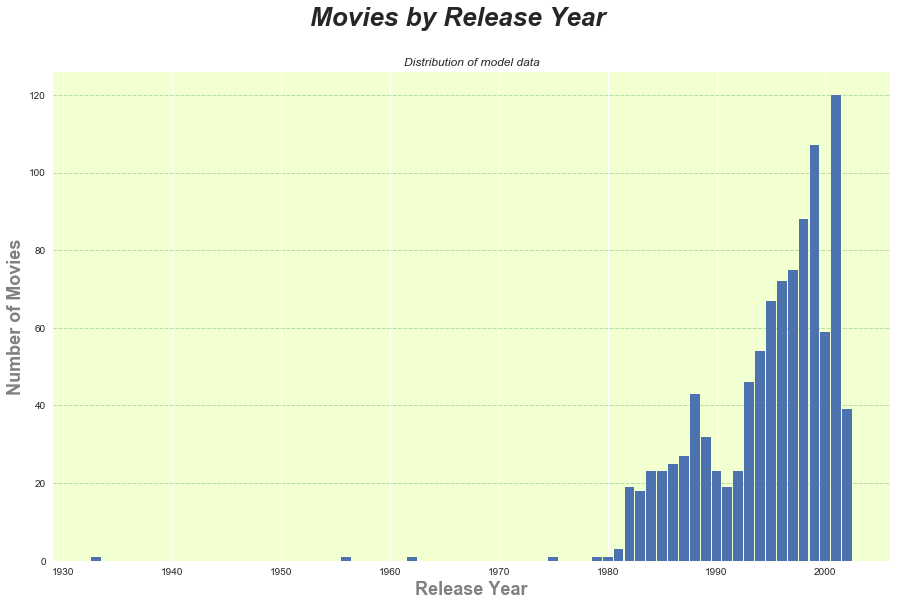

In [18]:
#let us look at the spread of the data chosen
#movies by year

#format the chart
data=movies_df[['year','imdbId']].groupby('year').size()
f,ax=plt.subplots(figsize=(15,9))
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax.set_facecolor(color='#f1ffd1')
plt.suptitle('Movies by Release Year', weight='bold',style ='italic',fontsize=26)
plt.title('Distribution of model data',style='italic',weight='light')
ax.set_xlabel('Release Year',weight='bold',color='grey',fontsize=18)
ax.set_ylabel('Number of Movies',weight='bold',color='grey',fontsize=18)

#plot the chart
plt.bar(data.keys(),data.values,width=0.9)
#plt.savefig('movies_by_year.jpg')
plt.show()


From the above chart we see that most of the movies that have been chosen to build this mode are the ones made after 1980 and the later years have more movies. * This could be an anomaly of the data that has been chosen. * I tried to find the total number of movies that been made by year, while there is no definitive source for this information, there are a couple of sites which  has some information. As per https://www.the-numbers.com/market/ the number of movies made from 1995 have more or less remained the same. As per http://members.chello.nl/~a.degreef/Filmnummers.html which includes movies in other languages as well, the number of movies being made hit its peak in the 1930s - 1940s. After that it starts to decline till 1970's and has been on an upward trend from there on.

In [19]:

genre_labels = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
'Crime', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
'Western']

genre_movie_count = [movies_df.Action.sum(), movies_df.Adventure.sum(), movies_df.Animation.sum(),movies_df.Children.sum(),movies_df.Comedy.sum(),
 movies_df.Crime.sum(),movies_df.Drama.sum(),movies_df.Fantasy.sum(),movies_df['Film-Noir'].sum(),
 movies_df.Horror.sum(),movies_df.IMAX.sum(),movies_df.Musical.sum(),movies_df.Mystery.sum(),movies_df.Romance.sum(),
 movies_df['Sci-Fi'].sum(),movies_df.Thriller.sum(),movies_df.War.sum(),movies_df.Western.sum()
]

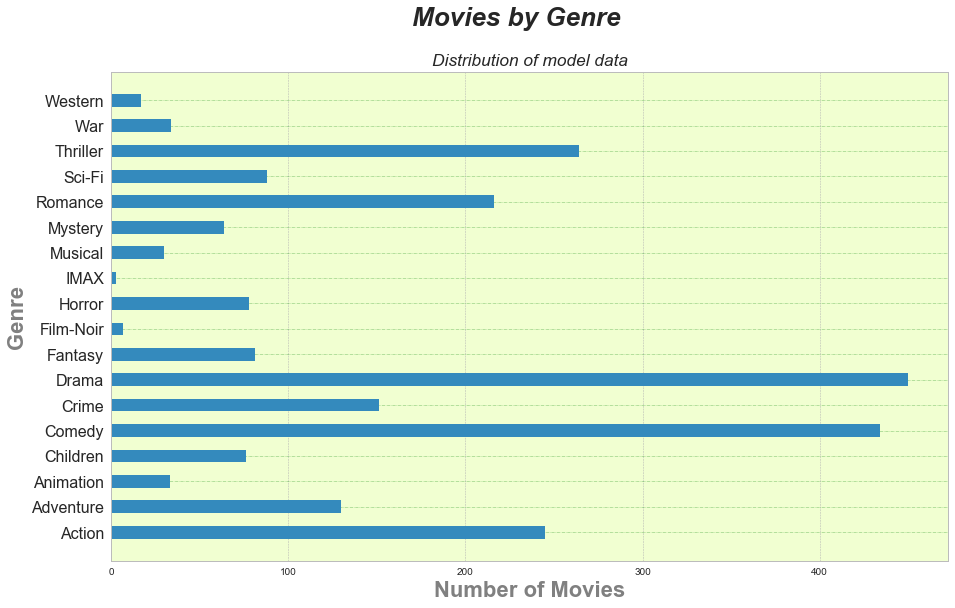

In [129]:
#let us look at the count of the genre
#movies by genre; note that the sum of all genres will be greater than the sum of the total number of movies
#because some movies have been tagged with more than one genre

f,ax=plt.subplots(figsize=(15,9))
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax.set_facecolor(color='#f1ffd1')
plt.suptitle('Movies by Genre', weight='bold',style ='italic',fontsize=26)
plt.title('Distribution of model data',style='italic',weight='light')
val_labels = genre_labels
y_pos = np.arange(len(genre_labels))
vals = genre_movie_count

ax.barh(y_pos, vals, align='center',height=0.5)

ax.set_ylabel('Genre',weight='bold',color='grey',fontsize=22)
ax.set_xlabel('Number of Movies',weight='bold',color='grey',fontsize=22)
ax.set_yticks(y_pos)
ax.set_yticklabels(val_labels,fontsize=16)

#plt.savefig('movies_by_genre1.jpg')

plt.show()

From the above chart we see that the top most genre is Drama closely followed by Comedy. The other top genre of movies are Thrillers, Action and Romance.

In [132]:
# check if the number of lead roles offered to ladies have gone up
#using only movies released after 1980 since the data before that is very sparse
data=movies_df[movies_df.year>1980]
data=pd.DataFrame(data[['year','actor1_gender']].groupby(['year','actor1_gender']).size()).unstack().fillna(0)
data.columns=['Female','Male']
data=data.reset_index()
data['Female_lead_actor_pct']=data['Female']/(data['Male']+data['Female'])

In [133]:
data.head(3)

,year,Female,Male,Female_lead_actor_pct
0,1981,0.0,3.0,0.000000
1,1982,2.0,17.0,0.105263
2,1983,5.0,13.0,0.277778


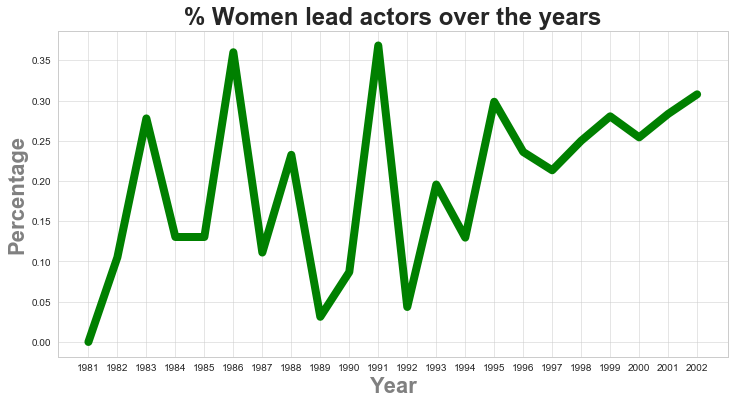

In [140]:
f,ax=plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")
x=data.year
y=data.Female_lead_actor_pct
plt.plot(y,color='green',linewidth=8)
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(data.year)
plt.title('% Women lead actors over the years',weight='bold',fontsize=24)
ax.set_ylabel('Percentage',weight='bold',color='grey',fontsize=22)
ax.set_xlabel('Year',weight='bold',color='grey',fontsize=22)

plt.show()

The % of lead roles given to women actors have remained more or less constant

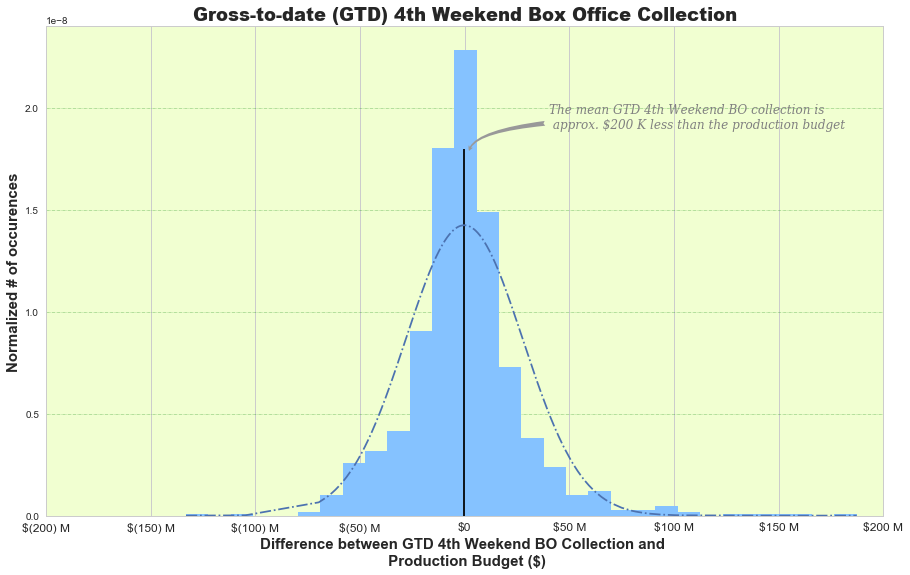

In [24]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=sorted(movies_df['abs_measure'])
mean=np.mean(data)

std=np.std(data)
fit = stats.norm.pdf(data, np.mean(data), np.std(data))  #this is a fitting indeed

ax.set_title('Gross-to-date (GTD) 4th Weekend Box Office Collection',fontsize=18,weight='extra bold')
ax.set_xlabel('Difference between GTD 4th Weekend BO Collection and \n Production Budget ($)',fontsize=15,weight='bold')
ax.set_ylabel('Normalized # of occurences',fontsize=15,weight='bold')
xmin,xmax=ax.get_xbound()
ymin,ymax=ax.get_ybound()
ax.set_xlim(-2e8,2e8)
ax.set_xticklabels(['$(200) M','$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M'],fontsize=12)


ax.annotate('The mean GTD 4th Weekend BO collection is \n approx. $200 K less than the production budget',
            xy=(0.02e8,1.78e-8), xycoords='data',color='grey',
            xytext=(80, 50), textcoords='offset points',
            size=12,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')

#ax.spines['bottom'].set_smart_bounds(True)

plt.plot(data,fit,'-.')
plt.hist(data,bins=30,normed=True,color='#85C2FF')
plt.vlines(mean,ymin,1.8e-8)
ax.spines['top'].set_visible(True)
#plt.savefig('GTD_4thWkdn_BO_Collection_Dist.jpg')
plt.show()

The above chart shows the distribution of the difference between the gross-to-date (GTD) box office collection and the movie production budget. The distribution roughly follows a Normal distribution and on an average, the movies GTD 4th weekend collection is approximately \$200 K less than the production budget. At the extremes, there are few movies that have made as much as \$250 Million more than the production budget and there are few that are short by $150 M compared to the production budget.

In [25]:
#mean from the above chart
mean

-212028.75766567755

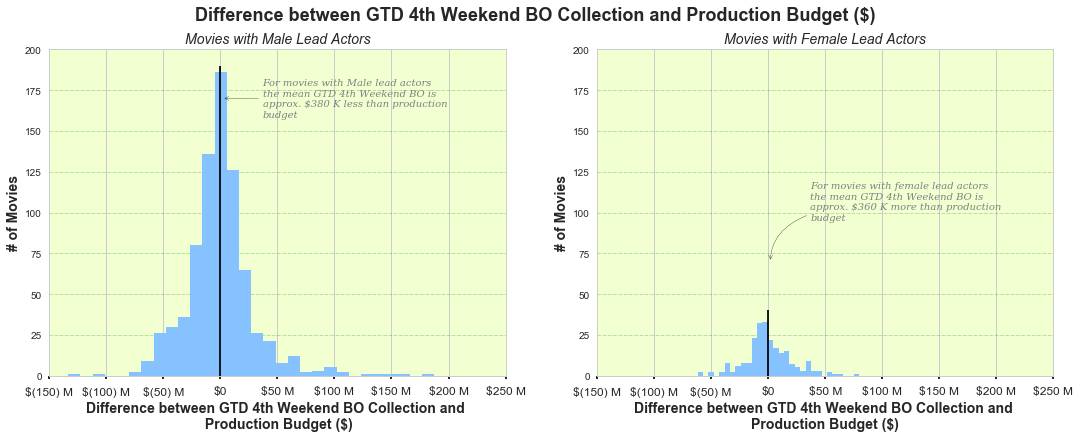

In [26]:
f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=200
btm=0.0
lft=-1.5e8
rght=2.5e8

plt.suptitle('Difference between GTD 4th Weekend BO Collection and Production Budget ($)',fontsize=18,weight='bold')


m_data=movies_df[movies_df['actor1_gender']=='Male']['abs_measure']
m_mean=np.mean(m_data)

ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax0.set_title('Movies with Male Lead Actors',fontsize=14,style='italic')
ax0.set_xlabel('Difference between GTD 4th Weekend BO Collection and \n Production Budget ($)',fontsize=14,weight='bold')
ax0.set_ylabel('# of Movies',fontsize=14,weight='bold')
ax0.set_xlim(left=lft,right=rght,auto=False)
ax0.set_xticklabels(['$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M','$250 M'],fontsize=12)
ax0.set_ylim(bottom=btm,top=top,auto=False)
ax0.annotate('For movies with Male lead actors \nthe mean GTD 4th Weekend BO is \napprox. $380 K less than production\nbudget',
            xy=(0.02e8,top*0.85), xycoords='data',color='grey',
            xytext=(40, 20), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="->",
                            fc="grey", ec="k",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')
ax0.tick_params('x', length=3, width=2, which='major')

ax0.hist(m_data,bins=30,color='#85C2FF')
ax0.vlines(mean,0,top*0.95)



f_data=movies_df[movies_df['actor1_gender']=='Female']['abs_measure']
f_mean=np.mean(f_data)

ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax1.set_title('Movies with Female Lead Actors',fontsize=14,style='italic')
ax1.set_xlabel('Difference between GTD 4th Weekend BO Collection and \nProduction Budget ($)',fontsize=14,weight='bold')
ax1.set_ylabel('# of Movies',fontsize=14,weight='bold')
ax1.set_xlim(left=lft,right=rght,auto=False)
ax1.set_xticklabels(['$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M','$250 M'],fontsize=12)
ax1.set_ylim(bottom=btm,top=top,auto=False)
#ax1.text(0.4e8,top*0.35,'$\mu=%.0f$' %(f_mean))
ax1.tick_params('x', length=3, width=2, which='major')
ax1.annotate('For movies with female lead actors \nthe mean GTD 4th Weekend BO is \napprox. $360 K more than production\nbudget',
            xy=(0.02e8,top*0.35), xycoords='data',color='grey',
            xytext=(40, 80), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="->",
                            fc="grey", ec="k",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')

#ax1.plot(f_data,fit,'-.')
ax1.hist(f_data,bins=30,color='#85C2FF')
ax1.vlines(mean,0,top*0.2)

#plt.savefig('Female_Male_4th_GTD_dist.jpg')
plt.show()

The above charts show the difference between the gross-to-date (GTD) 4th weekend box office collection and the movie production budget. The chart on the left shows the chart for movies with male lead actors and the one on the right is for movies with female lead actors. The above charts confirms what everyone suspects that there is huge gender gap in the movie industry with most lead characters being played by male. ** The surprising fact is that the movies with female lead actors are more successful than the ones with male lead actor. ** The 4th weekend GTD box office collection for movies with female lead actors is \$ 560 K more than the production budget, whereas, the same for a movie with a male lead actor is \$1.5 Million less than the production budget.

In [27]:
m_mean,f_mean

(-380170.72250639385, 362150.3537117904)

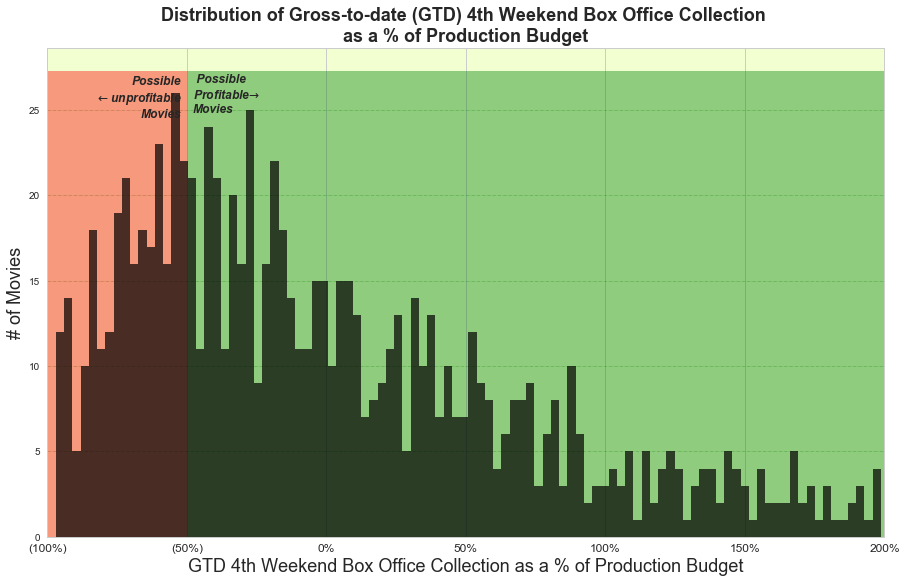

In [28]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

#include all movies whose 4th weekend box office collection is less than
#200% of the production budget, the rest are considered outliers
data=(movies_df[movies_df['pcnt_measure']<2]['pcnt_measure'])


ax.set_title('Distribution of Gross-to-date (GTD) 4th Weekend Box Office Collection \nas a % of Production Budget',
             fontsize=18,weight='bold')
ax.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=18)
ax.set_xlim(-1,2)
ax.set_xticklabels(['(100%)','(50%)','0%','50%','100%','150%','200%'],fontsize=12)
ax.set_ylabel('# of Movies',fontsize=18)


#plt.text(0,0.8,'$\mu=%.2f$ percent' %(mean*100))

#plt.plot(data,fit,'-.',linewidth=4)
plt.hist(data,bins=100,normed=False,color='k',alpha=0.7)
#plt.vlines(mean,ymin,0.8)
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.fill_between([xmin,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
plt.text(-.52,.9*ymax,'Possible\n$\u2190$ unprofitable\nMovies',horizontalalignment='right',style='italic',weight='bold')
plt.text(-0.48,.91*ymax,' Possible\nProfitable$\u2192$ \nMovies',horizontalalignment='left',style='italic',weight='bold')

ax.fill_between([-0.5,xmax], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)
#plt.savefig('dist_4th_Wknd_GTD_pcnt_prd_budge.jpg')
plt.show()

The above chart shows the distribution of the percentage measure (Difference between 4th weekend box office collection as a percentage of the movie production budget). The objective of this is to find how many movies are probably successful and how many are not. There are lot of expenses that go into a movie and there is no clear information if a movie has made profit or not. The major categories of expenses are production costs, distribution costs and marketing costs. The revenue for a movie comes from many sources, the broad categories of revenue streams are box office collection, media streaming, tv rights and merchandising. Based on various materials that i could find on the internet, i have considered an approximation that by the fourth weekend, if the box office collection is at least 50% of the production budget, it is a fair indicator of movie success

Below are some pages that have some details / discussion on accounting and financials success of movies.

https://www.quora.com/How-much-money-as-a-percentage-of-its-budget-does-a-Hollywood-movie-need-to-gross-to-actually-make-a-profit

https://movies.stackexchange.com/questions/12882/how-much-of-a-films-revenue-comes-from-its-cinema-release

https://en.wikipedia.org/wiki/Hollywood_accounting

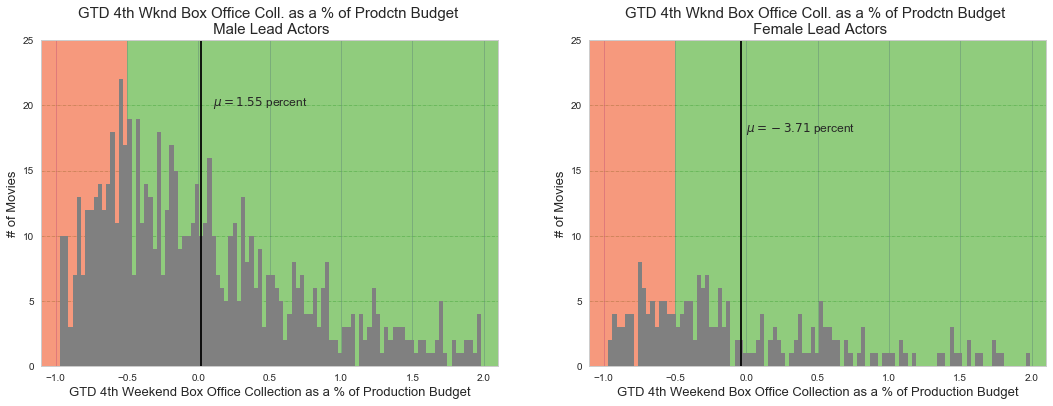

In [29]:
temp_df=movies_df[movies_df['pcnt_measure']<2]

f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=25
btm=0.0
lft=-1.1
rght=2.1
#For Male Lead Actor
ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Male']['pcnt_measure']
mean=np.mean(data)

ax0.hist(data,bins=100,color='grey')

ax0.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Male Lead Actors',fontsize=15)
ax0.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=13)
ax0.set_ylabel('# of Movies',fontsize=13)
ax0.text(.1,20,'$\mu=%.2f$ percent' %(mean*100))
ax0.set_xlim(left=lft,right=rght,auto=False)
ax0.set_ylim(bottom=btm,top=top,auto=False)
#xmin,xmax=ax0.get_xlim()
#ymin,ymax=ax0.get_ylim()
ax0.vlines(mean,btm,50)


ax0.fill_between([lft,-0.5], btm,top, facecolor='red', alpha = .4, interpolate=True)
ax0.fill_between([-0.5,rght], btm,top, facecolor='green', alpha = .4, interpolate=True)

#For Female Lead Actor
ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Female']['pcnt_measure']
mean=np.mean(data)

ax1.hist(data,bins=100,color='grey')

ax1.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Female Lead Actors',fontsize=15)
ax1.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=13)
ax1.set_ylabel('# of Movies',fontsize=13)
ax1.text(0,18,'$\mu=%.2f$ percent' %(mean*100))
ax1.set_xlim(left=lft,right=rght,auto=False)
ax1.set_ylim(bottom=btm,top=top,auto=False)

ax1.vlines(mean,btm,50)
xmin,xmax=ax1.get_xlim()
ymin,ymax=ax1.get_ylim()

ax1.fill_between([lft,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
ax1.fill_between([-0.5,rght], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)

plt.show()

The above charts are same as the previous one, except that these show the difference when the lead actor (actor 1) is a male actor or a female actor. As expected, the number of movies with male lead actors is more than female lead actor based movies.

In [31]:
temp_df=movies_df[['release_date_upd','pcnt_measure']]
temp_df['rel_month']=temp_df['release_date_upd'].apply(lambda x:calendar.month_abbr[x.month])
temp_df=temp_df[temp_df.pcnt_measure<2]

C:\Anac\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


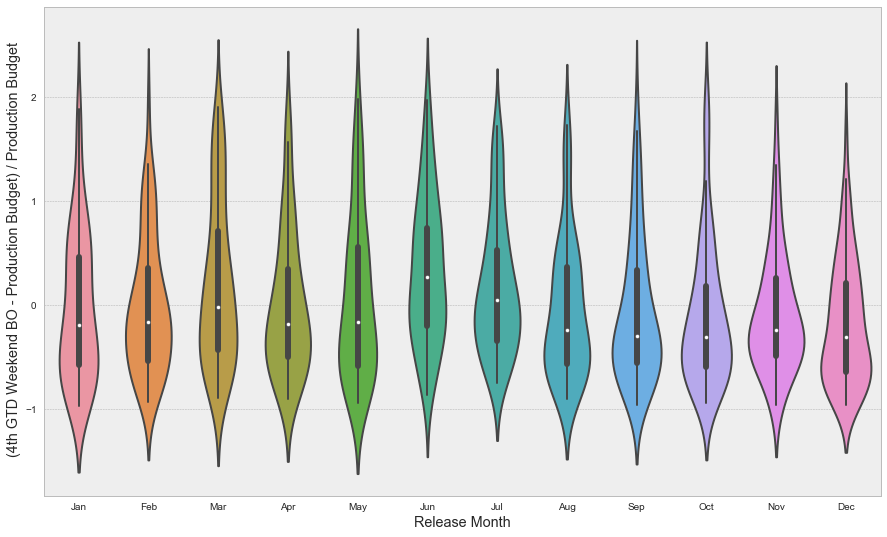

In [33]:
f,ax=plt.subplots(figsize=(15,9))
plt.style.use('bmh')
sns.violinplot(x=temp_df['rel_month'],y=temp_df['pcnt_measure'],
               order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Release Month')
ax.set_ylabel(' (4th GTD Weekend BO - Production Budget) / Production Budget')
#plt.savefig('movie_rel_month_violin_plot.jpg')
plt.show()

The above chart shows violin plots of movies grouped by the release month. The clear result is that * movies that are released during summer * are more successful than any other seasons. The next best season for movies seem to be Spring season. 

In [34]:
#excluding 2 directors who are outliers
(movies_df['director_score']>100).sum()

0

In [35]:
#excluding 2 directors who are outliers
temp_df=movies_df[movies_df['director_score']<100]

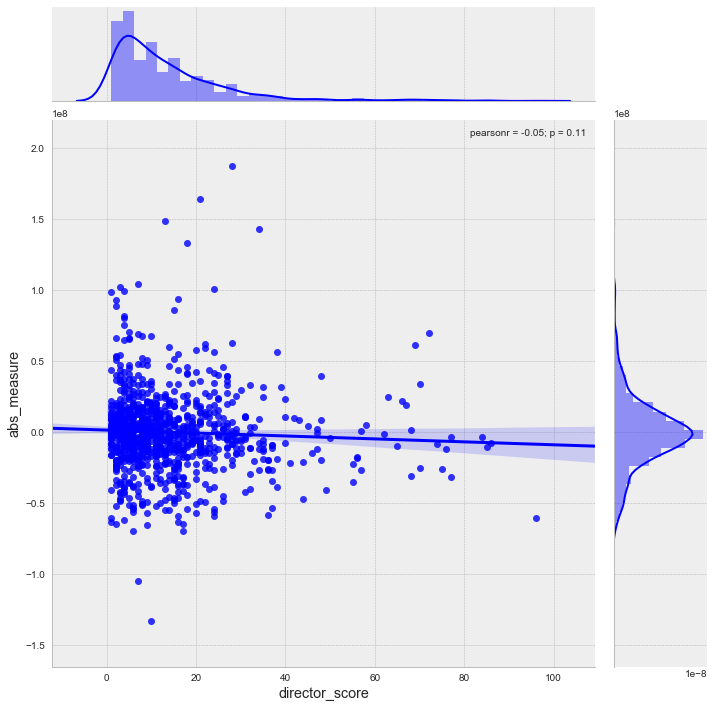

In [36]:
sns.jointplot(temp_df['director_score'], temp_df['abs_measure'],  kind="reg", color="b", size=10)
plt.show()
#plt.tight_layout()

The above chart shows the correlation between the director score and the absolute measure. From the chart, it seems that there is not much correlation between these two.

In [51]:
movies_df['actor1_score'].describe()

count    1011.000000
mean       33.454006
std        22.111343
min         1.000000
25%        19.000000
50%        29.000000
75%        43.000000
max       220.000000
Name: actor1_score, dtype: float64

In [37]:
#excluding 13 actor1 who are outliers
(movies_df['actor1_score']>100).sum()

11

In [48]:
#excluding 13 actor1 who are outliers
temp_df=movies_df[movies_df['actor1_score']<100]
temp_df=temp_df[temp_df.pcnt_measure<3]

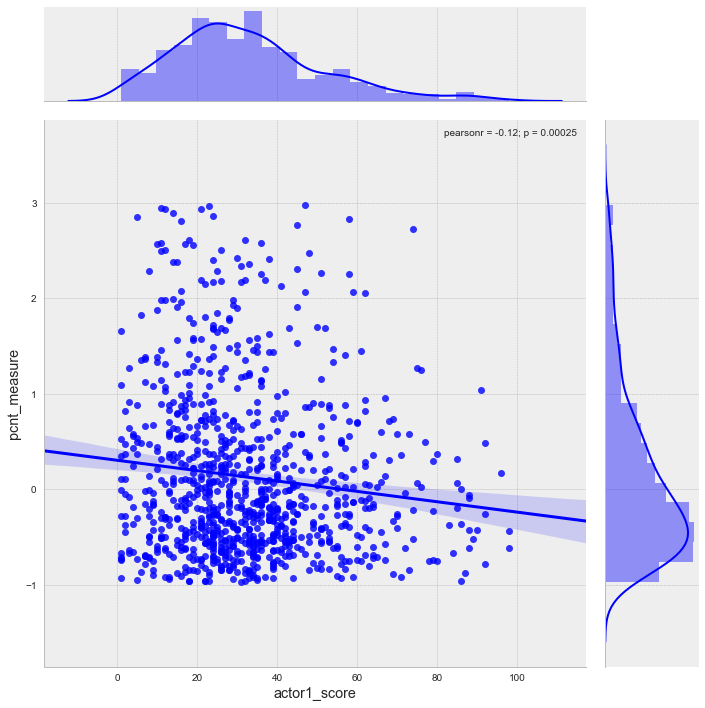

In [49]:
sns.jointplot(temp_df['actor1_score'], temp_df['pcnt_measure'],  kind="reg", color="b", size=10)
#plt.savefig('actor1_corr.jpg')
plt.show()

The above chart shows the correlation between the lead actor score and the absolute measure. From the chart, it seems that there is a slight negative correlation between the lead actor's score and the movie success. It could be that actors past their prime may not be as successful as upcoming actors.

In [44]:
#excluding outliers
temp_df=movies_df[movies_df['pcnt_measure']<3]

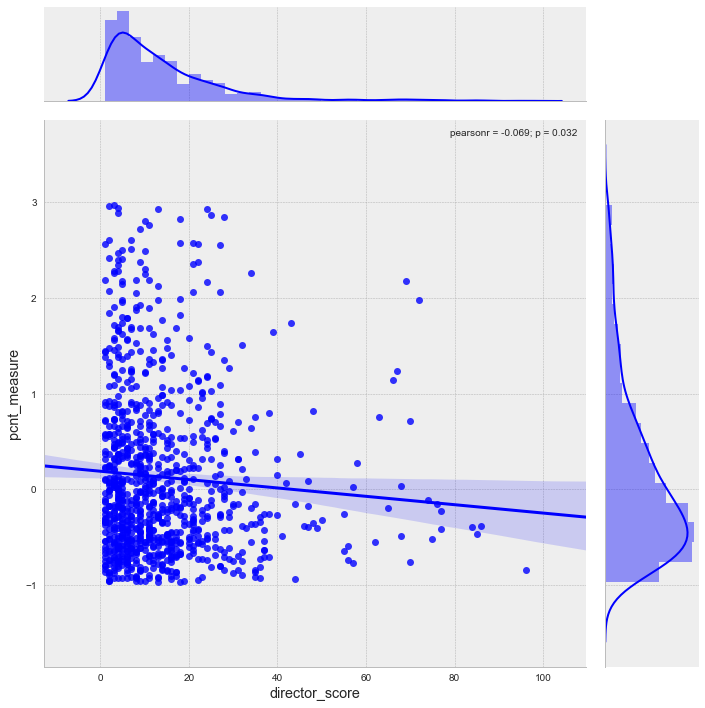

In [45]:
sns.jointplot(temp_df['director_score'], temp_df['pcnt_measure'],  kind="reg", color="b", size=10)
#plt.savefig('director_corr.jpg')
plt.show()

The above chart shows the correlation between the director score and the percent measure. From the chart, it seems that there is not much correlation between these two. However, the correation between the percent measure and the director score is more than the correlation between absolute measure and the director score. 

In [46]:
temp_df=movies_df[movies_df['pcnt_measure']<3]

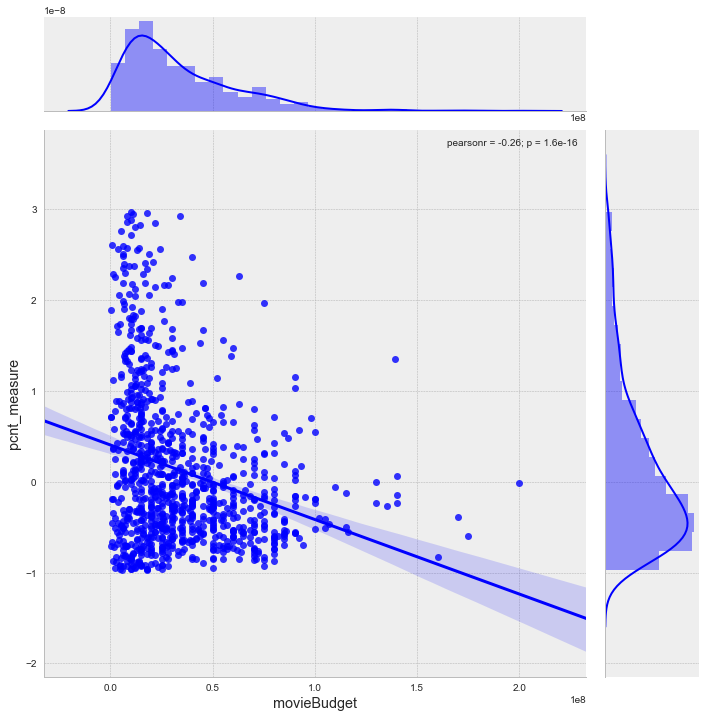

In [47]:
sns.jointplot(temp_df['movieBudget'], temp_df['pcnt_measure'],  kind="reg", color="b", size=10)
plt.show()

The above chart shows the correlation between the movie budget and the percent measure. There seems to be a negative correlation between the movie budget and it's success. The greater the movie budget, there is increased chance that it will be difficult to make it financially successful

In [50]:
temp_df=movies_df[movies_df['pcnt_measure']<3]
temp_df=temp_df[temp_df['year']>1980]

source = ColumnDataSource(data=dict(
    x1=temp_df['actor1_score'],
    x2=temp_df['actor2_score'],
    x3=temp_df['actor3_score'],
    x4=temp_df['actor4_score'],
    x5=temp_df['director_score'],
    y=temp_df['pcnt_measure'],
    size=(abs(temp_df['abs_measure'])/1e7)*2,
    desc=temp_df['title'],
    size_desc=temp_df['abs_measure']))

hover = HoverTool(tooltips=[
    ("Movie", "@desc"),
    ("4th Wknd BO (in $)", "@size_desc"),
])

p = figure(plot_width=900, plot_height=600,title="Correlation Between Actors / Directors and Box Office Collection", 
           x_axis_label='Actor / Director Score', 
           y_axis_label='% of 4th Weekend Box office Collection\nCompared the Production Budget',
           tools="pan,wheel_zoom,box_zoom,reset")
p.add_tools(hover)


    
p.circle(x='x1', y='y',size='size',alpha=0.5,legend='Actor 1',source=source,
        color='orange')
p.circle(x='x2', y='y',size='size',alpha=0.5,legend='Actor 2',source=source,
        color='red')
p.circle(x='x3', y='y',size='size',alpha=0.5,legend='Actor 3',source=source,
        color='green')
p.circle(x='x4', y='y',size='size',alpha=0.5,legend='Actor 4',source=source,
        color='blue')
p.circle(x='x5', y='y',size='size',alpha=0.5,legend='Director',source=source,
        color='grey')

p.legend.location = "top_right"
p.legend.click_policy="hide"
show(p)

The above interactive chart shows the relationship between the actor / director scores and the percentage measure. The size of the bubble represents the magnitude of the indicator.

In [51]:
#Following are probably outliers since they have had exterme success
movies_df[(movies_df['pcnt_measure']>5)][['title','movieBudget','movie_4th_wknd_bo']]

,title,movieBudget,movie_4th_wknd_bo
49,"Brothers McMullen, The (1995)",25000,4656069
74,Clerks (1994),27575,624630
212,Around the World in 80 Days (1956),6000000,42000000
224,Swingers (1996),200000,3121408
240,Raiders of the Lost Ark (Indiana Jones and the...,18000000,181718672
277,Jaws (1975),8000000,49516476
321,Air Bud (1997),3000000,20249873
335,Chasing Amy (1997),250000,3886506
403,Pi (1998),60000,601702
409,"Breakfast Club, The (1985)",1000000,19149143


In [52]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'release_date_upd', 'actor1_male', 'actor1_female', 'actor2_male',
       'actor2_female', 'actor3_male', 'actor3_female', 'actor4_male',
       'actor4_female', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar',
       'May', 'Nov', 'Oct', 'Sep', 'abs_measure', 'pcnt_measure'],
      dtype='object')

***
The below steps build the data to be input to the ML model

In [59]:
movies_model_df=movies_df[movies_df['pcnt_measure']<=10]

In [60]:
movies_df_model_data = movies_model_df[['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_score',
        'actor2_score', 'actor3_score',
       'actor4_score', 'director_score', 
       'movieBudget', 'movie_4th_wknd_bo', 
       'year', 
       'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep',
       'actor1_male', 'actor1_female', 'actor2_male', 'actor2_female',
       'actor3_male', 'actor3_female', 'actor4_male', 'actor4_female','abs_measure', 'pcnt_measure' ]]

In [61]:
movies_df_model_data=movies_df_model_data.set_index('imdbId')

In [62]:
#check for nulls
np.sum(np.isnan(movies_df_model_data))

Action               0
Adventure            0
Animation            0
Children             0
Comedy               0
Crime                0
Documentary          0
Drama                0
Fantasy              0
Film-Noir            0
Horror               0
IMAX                 0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Thriller             0
War                  0
Western              0
actor1_score         0
actor2_score         0
actor3_score         0
actor4_score         1
director_score       0
movieBudget          0
movie_4th_wknd_bo    0
year                 0
Apr                  0
Aug                  0
Dec                  0
Feb                  0
Jan                  0
Jul                  0
Jun                  0
Mar                  0
May                  0
Nov                  0
Oct                  0
Sep                  0
actor1_male          0
actor1_female        0
actor2_male          0
actor2_female        0
actor3_male

In [63]:
#remove any null values
movies_df_model_data['actor4_score'].fillna(0,inplace=True)

In [64]:
#check if any null values are present
np.isnan(movies_df_model_data['actor4_score']).sum()

0

In [65]:
#drop the 4th weekend box office column since this is an information that will not
#be available before the release of a movie
movies_df_model_data.drop([movies_df_model_data.columns[25]],axis=1,inplace=True)

In [66]:
#features
movies_df_model_data.columns[0:46].values

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_score', 'actor2_score', 'actor3_score',
       'actor4_score', 'director_score', 'movieBudget', 'year', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'actor1_male', 'actor1_female', 'actor2_male',
       'actor2_female', 'actor3_male', 'actor3_female', 'actor4_male',
       'actor4_female'], dtype=object)

In [67]:
#to be predicted
movies_df_model_data.columns[47]

'pcnt_measure'

Setup training and test data

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
train_df, test_df = train_test_split(movies_df_model_data,test_size=0.2,random_state=1)

In [70]:
X_train=train_df[movies_df_model_data.columns[0:46].values]
y_train=train_df['pcnt_measure']
X_test=test_df[movies_df_model_data.columns[0:46].values]
y_test=test_df['pcnt_measure']

In [71]:
#find the sum of squares if we just use mean of 4th weekend percentage
#as the prediction; any model should be better than this
mean=np.mean(y_train)
np.sum((y_train-mean)**2),np.sum((y_train)**2)

(1330.9695868953318, 1401.7440482902884)

In [72]:
mean=np.mean(y_test)
np.sum((y_test-mean)**2),np.sum((y_test)**2)

(294.6296898563578, 313.1639977616787)

### Bayesian Ridge Regression
***

In [73]:
from sklearn import linear_model

In [74]:
from sklearn.grid_search import GridSearchCV

In [75]:
mdl = linear_model.BayesianRidge(n_iter=2)

In [76]:
mdl.fit(X_train,y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)

In [77]:
np.sum((mdl.predict(X_train)-y_train)**2)

1052.7260823644967

Find the hyper-parameters using Grid Search

In [78]:
#parameters = {"alpha_1": [1e-4,1e-5,1e-6,1e-7,0],"lambda_1":[0.001,0.01,0.05,.1,.2],"n_iter":[2,5,6,8]}
#parameters = {"alpha_1": [.1,.001,.0001,.00001]}
parameters = {"alpha_1": [1e-4,1e-5,1e-6,1e-7,0],"lambda_1":[0.001,0.01,0.05,.1,.2]}
BRmdl=linear_model.BayesianRidge(n_iter=2)

In [79]:
%%time
fitmodel = GridSearchCV(BRmdl, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: BayesianRidge(alpha_1=0, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.2, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)
***best params: {'alpha_1': 0, 'lambda_1': 0.2}
***best score: -0.7900045880105067
Wall time: 275 ms


In [80]:
BRmdl=fitmodel.best_estimator_

In [81]:
BRmdl.fit(X_train,y_train)

BayesianRidge(alpha_1=0, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.2, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)

In [82]:
(np.sum((BRmdl.predict(X_train)-y_train)**2))

1052.8227804880744

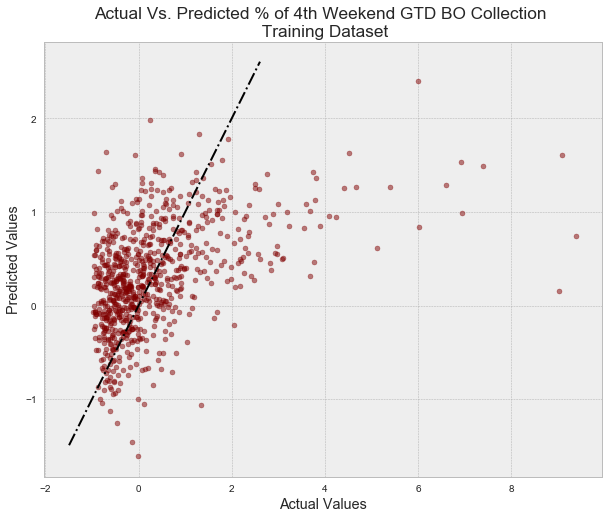

In [83]:
f,ax=plt.subplots(figsize=(10,8))

plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Training Dataset')
x,y=y_train,BRmdl.predict(X_train)
plt.scatter(x,y,alpha=0.5,s=25,color='maroon')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=2,linestyle='-.')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

The above chart plots the predicted percent measure against the actual percent measure. If the model were perfect, all the points would be on the black broken line.

From the above chart, we can see that the model works better when the actual values are roughly between -0.75 and +1.0. This means that the model fails badly when the actual outcomes are extreme, i.e. a movie was a runaway success or a colossal failure.

In [84]:
np.sum((BRmdl.predict(X_test)-y_test)**2)

223.81701852755813

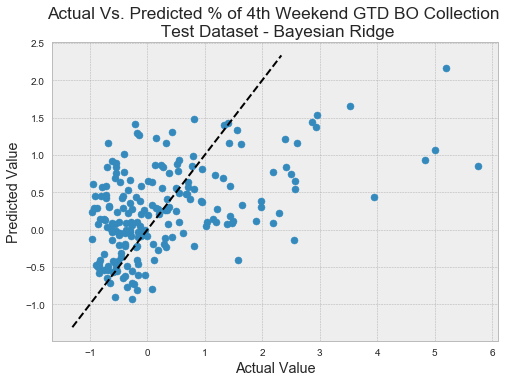

In [85]:
#f,ax=plt.subplots(figsize=(12,12))
f,ax=plt.subplots()

plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Test Dataset - Bayesian Ridge')
plt.scatter(x=y_test,y=BRmdl.predict(X_test))
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=2,linestyle='--')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
#plt.savefig('BayesianRidge_pred_act.jpg')
plt.show()

The above chart plots the actual and predicted values for the test dataset.

Below are the coeffecients of the features. The greater the magnitude, the greater the effect of the feature on the predicted value.

In [86]:
BRmdl.coef_[np.argsort(np.abs(BRmdl.coef_))[::-1][0:5]]
#movies_df_model_data.columns

array([ 0.30596843, -0.26558281, -0.24083944,  0.22672636, -0.2049148 ])

In [87]:
movies_df_model_data.columns[np.argsort(np.abs(BRmdl.coef_))[::-1][0:5]]

Index(['Jun', 'Drama', 'Sep', 'Horror', 'Dec'], dtype='object')

***
### Random Forest Regressor
***

In [88]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [90]:
np.sum((regr.predict(X_train)-y_train)**2)

668.0894809075742

In [91]:
np.sum((regr.predict(X_test)-y_test)**2)

225.26634352111208

Find the hyper-parameters using Grid Search

In [92]:
%%time
parameters = {"max_depth": [1,2,5,10,15]}
RFclf=RandomForestRegressor()
fitmodel = GridSearchCV(RFclf, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
***best params: {'max_depth': 5}
***best score: -0.7641770451120323
Wall time: 411 ms


In [93]:
RFRmdl=fitmodel.best_estimator_
RFRmdl.fit(X_train,y_train)
np.sum((RFRmdl.predict(X_train)-y_train)**2)

685.3831191349228

In [97]:
%%time
parameters = {"n_estimators": [5,10,15,20,25],"min_samples_split":[2,4,10],"min_samples_leaf":[1,2,4,8]}
mdl=RandomForestRegressor(max_depth=5)
fitmodel = GridSearchCV(mdl, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
***best params: {'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 25}
***best score: -0.741706968203875
Wall time: 5.65 s


In [98]:
RFRmdl=fitmodel.best_estimator_
RFRmdl.fit(X_train,y_train)
np.sum((RFRmdl.predict(X_train)-y_train)**2)

798.7170425103225

In [99]:
np.sum((RFRmdl.predict(X_test)-y_test)**2)

211.0798538457072

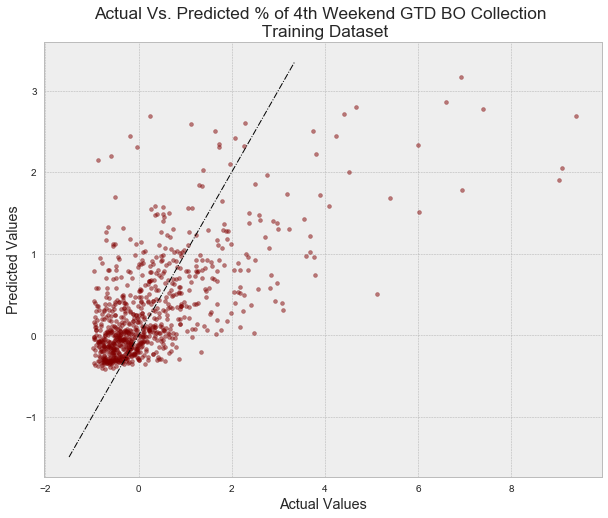

In [100]:
f,ax=plt.subplots(figsize=(10,8))

plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Training Dataset')
x,y=y_train,RFRmdl.predict(X_train)
plt.scatter(x,y,alpha=0.5,s=15,color='maroon')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='-.')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

From the sum of squares we can see that the performance of Random Forests Regressor is slightly better than the Bayesian Ridge Regression. The chart above shows that the predicted values using Random Forest Regressor are bunched closer to 0, whereas in Bayesian Ridge, it is a bit more spread out. The model works better when the actual values are roughly between -1 to 0.5.

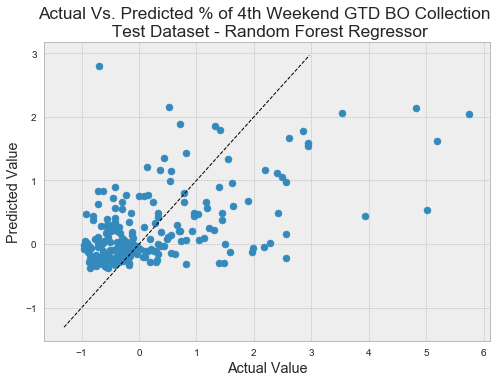

In [101]:
#f,ax=plt.subplots(figsize=(12,12))
f,ax=plt.subplots()

plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Test Dataset - Random Forest Regressor')
plt.scatter(x=y_test,y=RFRmdl.predict(X_test))
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='--')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
#plt.savefig('RandomForestRegressor_pred_act.jpg')
plt.show()

The above chart shows the performance of the Random Forests model on the test dataset. Performance of this model is better than Bayesian Ridge. This model seems to handle values upto 2.0 slightly better than the Bayesian Ridge.

Below are the most important features according to this model.

In [108]:
np.argsort(RFRmdl.feature_importances_)[::-1][:10]

array([24, 25,  7, 22, 20, 19, 23, 21, 31, 32], dtype=int64)

In [109]:
X_train.columns[np.argsort(RFRmdl.feature_importances_)[::-1]][:5]

Index(['movieBudget', 'year', 'Drama', 'actor4_score', 'actor2_score'], dtype='object')

***
### Support Vector Machine
***

In [102]:
from sklearn import svm

In [103]:
mdl = svm.SVR()
mdl.fit(X_train,y_train)
np.sum((mdl.predict(X_train)-y_train)**2)

644.2695565033495

In [104]:
np.sum((mdl.predict(X_test)-y_test)**2)

303.7507677145916

In [105]:
%%time
parameters = {"C": [1e-10,1e-5,1e-3,1e-2,1e-1,1],"gamma":["auto",0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
mdl=svm.SVR()
fitmodel = GridSearchCV(mdl, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.4,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
***best params: {'C': 0.1, 'gamma': 0.4}
***best score: -0.8005402119691597
Wall time: 6.87 s


In [106]:
SVMmdl=fitmodel.best_estimator_
SVMmdl.fit(X_train,y_train)
np.sum((SVMmdl.predict(X_train)-y_train)**2)

1315.2660513720743

In [107]:
np.sum((SVMmdl.predict(X_test)-y_test)**2)

321.6095996061856

***
### Decision Tree Regressor
***

In [108]:
from sklearn.tree import DecisionTreeRegressor

In [109]:
mdl = DecisionTreeRegressor()
mdl.fit(X_train,y_train)
np.sum((mdl.predict(X_train)-y_train)**2)

1.6125086805477734e-10

Looks like the model is overfitting.

In [110]:
np.sum((mdl.predict(X_test)-y_test)**2)

548.3700343822754

Find the hyper-parameters using Grid Search

In [111]:
%%time
#parameters = {"max_depth": [2,4,8,16],"min_samples_split":[2,4,10,20],"min_samples_leaf":[12,24,48,72,96], 
#              "max_features":["auto","sqrt","log2"]}
parameters = {"min_samples_split":[2,4,10,20],"min_samples_leaf":[12,24,48,72,96], 
              "max_features":["auto","sqrt","log2"]}

DTMdl=DecisionTreeRegressor()
fitmodel = GridSearchCV(DTMdl, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=48, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
***best params: {'max_features': 'auto', 'min_samples_leaf': 48, 'min_samples_split': 2}
***best score: -0.7667460543251482
Wall time: 459 ms


In [112]:
DTRmdl=fitmodel.best_estimator_
DTRmdl.fit(X_train,y_train)
np.sum((SVMmdl.predict(X_train)-y_train)**2)

1315.2660513720743

In [113]:
np.sum((DTRmdl.predict(X_test)-y_test)**2)

230.86902539420234

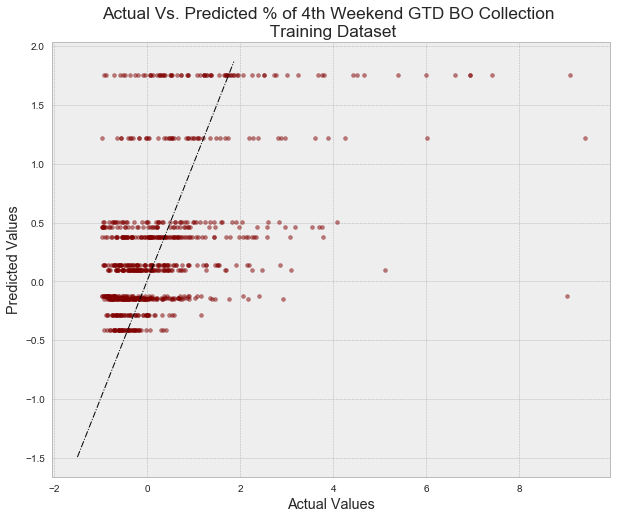

In [114]:
f,ax=plt.subplots(figsize=(10,8))

plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Training Dataset')
x,y=y_train,DTRmdl.predict(X_train)
plt.scatter(x,y,alpha=0.5,s=15,color='maroon')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='-.')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

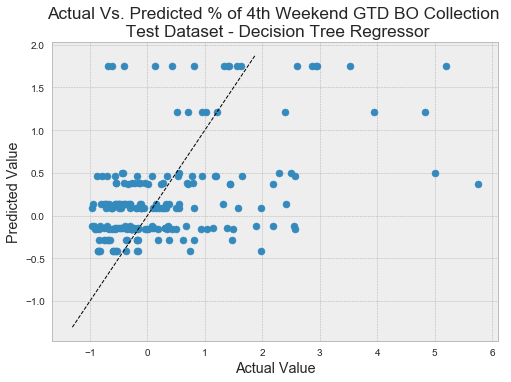

In [115]:
#f,ax=plt.subplots(figsize=(12,12))
f,ax=plt.subplots()

plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Test Dataset - Decision Tree Regressor')
plt.scatter(x=y_test,y=DTRmdl.predict(X_test))
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='--')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
#plt.savefig('DecisionTreeRegressor_pred_act.jpg')
plt.show()

Though the scores of this model are as good as other models, the prediction is not as useful. This model predicts only a few values.

Below are the important features as per this model.

In [124]:
np.argsort(DTRmdl.feature_importances_)[::-1][:10]

array([24,  7, 25, 19, 23,  0, 21,  6,  5,  1], dtype=int64)

In [125]:
X_train.columns[np.argsort(DTRmdl.feature_importances_)[::-1]][:5]

Index(['movieBudget', 'Drama', 'year', 'actor1_score', 'director_score'], dtype='object')

***
### Extra Trees Regressor
***

In [116]:
from sklearn.ensemble import ExtraTreesRegressor

In [117]:
mdl = ExtraTreesRegressor()
mdl.fit(X_train,y_train)
np.sum((mdl.predict(X_train)-y_train)**2)

5.149056932572317e-09

In [118]:
np.sum((mdl.predict(X_test)-y_test)**2)

274.2775276373368

In [119]:
%%time

parameters = {"max_depth": [1,2,5,10,15]}
ETMdl=ExtraTreesRegressor()
fitmodel = GridSearchCV(ETMdl, param_grid=parameters, scoring="neg_mean_absolute_error")
fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=5,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
***best params: {'max_depth': 5}
***best score: -0.774913933251384
Wall time: 350 ms


In [123]:
%%time
parameters = {"n_estimators": [5,10,15,20,25],"min_samples_split":[2,4,10],"min_samples_leaf":[1,2,4,8]}

ETMdl=ExtraTreesRegressor(max_depth=5)

fitmodel = GridSearchCV(ETMdl, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
#print('***grid scores:', fitmodel.grid_scores_)

***best estimator: ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=5,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=8,
          min_samples_split=4, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
***best params: {'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20}
***best score: -0.7489538405275504
Wall time: 4.55 s


In [124]:
ETMmdl=fitmodel.best_estimator_
ETMmdl.fit(X_train,y_train)
np.sum((ETMmdl.predict(X_train)-y_train)**2)

897.884963704218

In [125]:
np.sum((ETMmdl.predict(X_test)-y_test)**2)

226.67761199027825

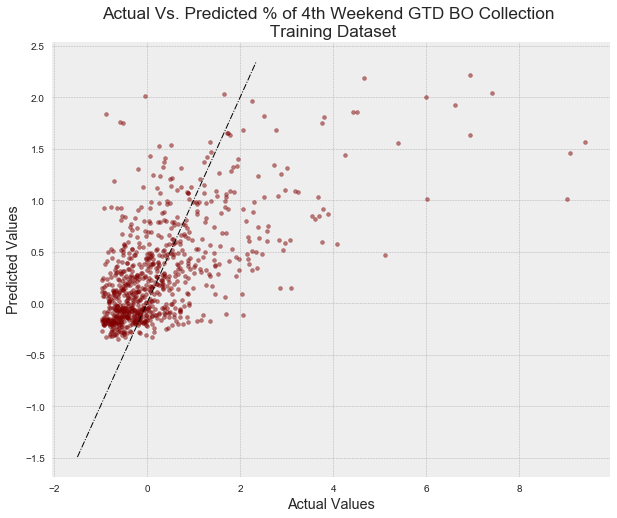

In [136]:
f,ax=plt.subplots(figsize=(10,8))

plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Training Dataset - Extra Trees Regressor')
x,y=y_train,ETMmdl.predict(X_train)
plt.scatter(x,y,alpha=0.5,s=15,color='maroon')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='-.')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

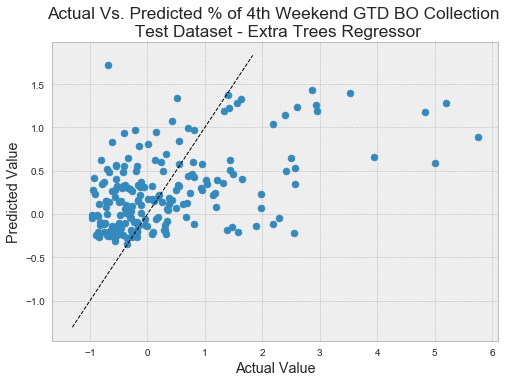

In [126]:
#f,ax=plt.subplots(figsize=(12,12))
f,ax=plt.subplots()

plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Test Dataset - Extra Trees Regressor')
plt.scatter(x=y_test,y=ETMmdl.predict(X_test))
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot([xmin,ymax],[xmin,ymax],color='k',linewidth=1,linestyle='--')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
#plt.savefig('ExtraTreesRegressor_pred_act.jpg')
plt.show()

This model's preformance is better than most other models and it seems to work better than other models in the extreme values.

Below are the most important feaures in this model

In [138]:
X_train.columns[np.argsort(ETMmdl.feature_importances_)[::-1]][:5]

Index(['movieBudget', 'year', 'Drama', 'Jun', 'Aug'], dtype='object')

***
From all the above, following are the key conclusions that one can make
1. Predicting success of a movie is a challenge, the success of a movie does not correlate strongly with any of the factors that affect a movie
2. However, there are certain features that have more importance than other in affecting the success of a movie, e.g. choice of actor are more important than the directors, drama genre movies are probably more successful and movies released during summer fare better than movies released in other months

The model created here is a very basic model, there are a lot of ways this can be improved. Some of the ideas that i have are
* Increasing the data, this is obvious, due to the limitation of time and resources, i have worked with only a small dataset
* Use text in the movie plot and movie summary to do key word analysis, the result of this can be added to the features
* Use additional features like number of theatres that the movie has been released in, languages released, etc.
